In [2]:
# Feature Selection Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Load cleaned and preprocessed dataset
df = pd.read_csv("../data/processed/combine_preprocessed.csv")

# Define targets
target_classification = df['draft_round']
target_regression = df['draft_ovr']

# Drop ID and target columns (assumes 'pos' already encoded, and 'school' is retained)
features = df.drop(columns=[
    'draft_year', 'draft_round', 'draft_ovr'
])

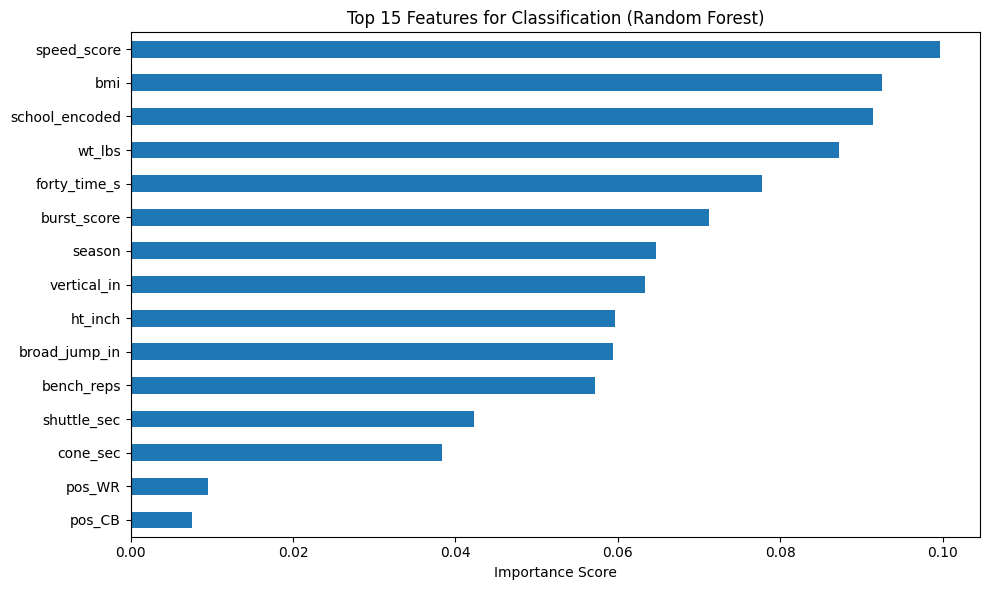

In [3]:
# ------------------------
# Feature Importance - Classification
# ------------------------
clf = RandomForestClassifier(random_state=42)
clf.fit(features, target_classification)
importances_clf = pd.Series(clf.feature_importances_, index=features.columns)

# Plot top features
plt.figure(figsize=(10, 6))
importances_clf.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Features for Classification (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

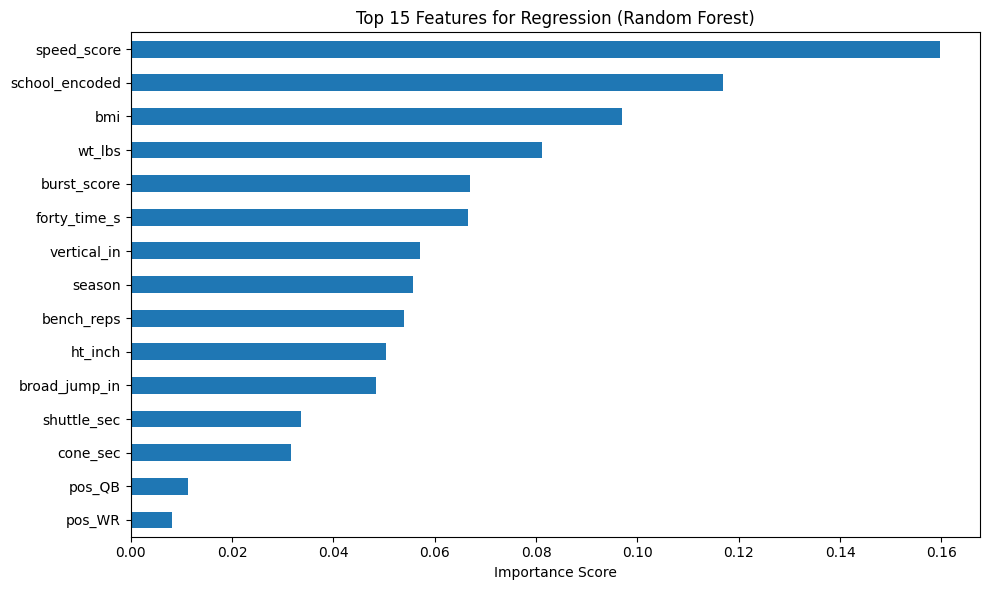

In [4]:
# ------------------------
# Feature Importance - Regression
# ------------------------
reg = RandomForestRegressor(random_state=42)
reg.fit(features, target_regression)
importances_reg = pd.Series(reg.feature_importances_, index=features.columns)

# Plot top features
plt.figure(figsize=(10, 6))
importances_reg.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Features for Regression (Random Forest)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [5]:
# Optionally save top features to CSV
importances_clf.sort_values(ascending=False).to_csv("../reports/feature_importance_classification.csv")
importances_reg.sort_values(ascending=False).to_csv("../reports/feature_importance_regression.csv")

/tmp/ipykernel_963956/687023195.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfe_class_ranking.values, y=rfe_class_ranking.index, palette="viridis")


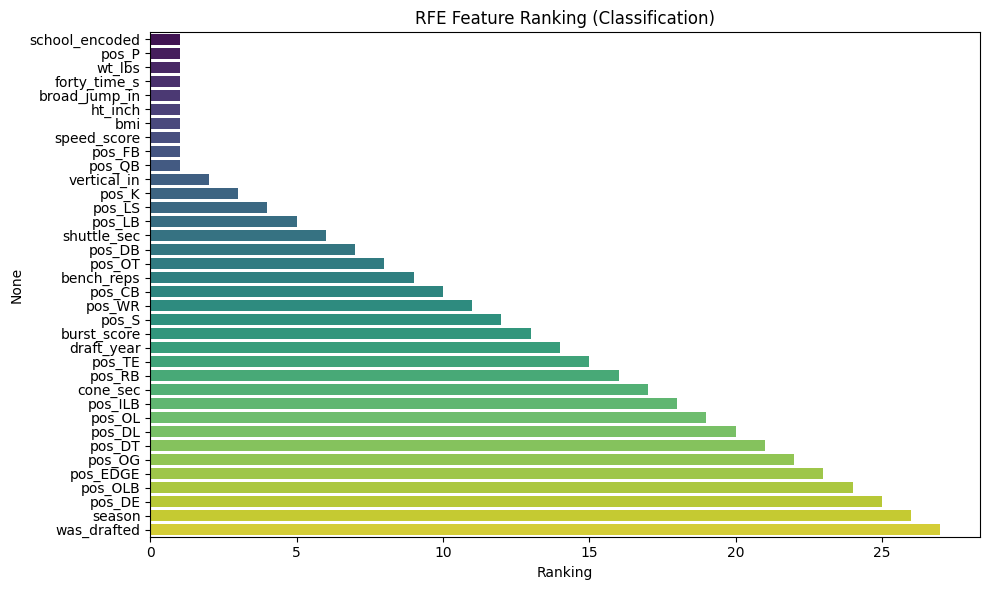

/tmp/ipykernel_963956/687023195.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfe_reg_ranking.values, y=rfe_reg_ranking.index, palette="magma")


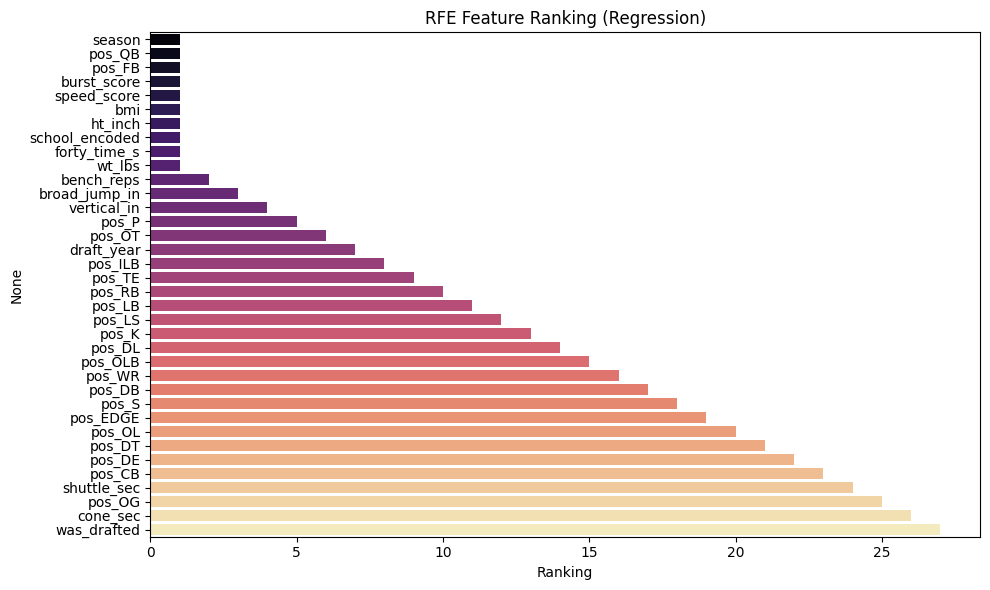

In [5]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

# Load preprocessed CSV from EDA step
df_clean = pd.read_csv("../data/processed/combine_preprocessed.csv")

# Set target columns
y_class = df_clean["draft_round"]
y_reg = df_clean["draft_ovr"]

# Drop target columns and any non-numeric or identifier features from features
X = df_clean.drop(columns=["draft_round", "draft_ovr"])

# Impute any remaining missing values with column means
X_imputed = X.fillna(X.mean(numeric_only=True))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Create directories if they don't exist
os.makedirs("data/eda", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# ========== Classification RFE ==========
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
rfe_class = RFE(log_reg, n_features_to_select=10)
rfe_class.fit(X_scaled, y_class)

# Save classification RFE results
rfe_class_ranking = pd.Series(rfe_class.ranking_, index=X_imputed.columns).sort_values()
rfe_class_ranking.to_csv("data/eda/rfe_classification.csv", header=["ranking"])

# Plot classification RFE
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_class_ranking.values, y=rfe_class_ranking.index, palette="viridis")
plt.title("RFE Feature Ranking (Classification)")
plt.xlabel("Ranking")
plt.tight_layout()
plt.savefig("plots/rfe_classification.png")
plt.show()

# ========== Regression RFE ==========
lin_reg = LinearRegression()
rfe_reg = RFE(lin_reg, n_features_to_select=10)
rfe_reg.fit(X_scaled, y_reg)

# Save regression RFE results
rfe_reg_ranking = pd.Series(rfe_reg.ranking_, index=X_imputed.columns).sort_values()
rfe_reg_ranking.to_csv("data/eda/rfe_regression.csv", header=["ranking"])

# Plot regression RFE
plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_reg_ranking.values, y=rfe_reg_ranking.index, palette="magma")
plt.title("RFE Feature Ranking (Regression)")
plt.xlabel("Ranking")
plt.tight_layout()
plt.savefig("plots/rfe_regression.png")
plt.show()


In [8]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression

# Load and prep the data
df_clean = pd.read_csv("../data/processed/combine_preprocessed.csv")
X = df_clean.drop(columns=["draft_round", "draft_ovr"])
y_class = df_clean["draft_round"]
y_reg = df_clean["draft_ovr"]

# Impute missing values
X_imputed = X.fillna(X.mean(numeric_only=True))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-Test Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

# ========== Classification ==========
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

print("=== Classification Report ===")
print(classification_report(y_test_c, y_pred_c))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_c))

# ========== Regression ==========
reg = LinearRegression()
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

mse = mean_squared_error(y_test_r, y_pred_r)
rmse = mse ** 0.5

print("\n=== Regression Evaluation ===")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2_score(y_test_r, y_pred_r):.2f}")



=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.25      0.30      0.28        63
         2.0       0.23      0.13      0.17        78
         3.0       0.17      0.28      0.21        71
         4.0       0.12      0.16      0.14        62
         5.0       0.14      0.12      0.13        60
         6.0       0.17      0.18      0.18        49
         7.0       0.00      0.00      0.00        45

    accuracy                           0.18       428
   macro avg       0.15      0.17      0.16       428
weighted avg       0.16      0.18      0.16       428


Confusion Matrix:
[[19 13 15 11  4  1  0]
 [19 10 21 14  8  6  0]
 [14  8 20 12 10  7  0]
 [ 6  3 23 10  5 14  1]
 [ 6  4 18 19  7  6  0]
 [ 5  4 11  8 10  9  2]
 [ 6  1 11 11  7  9  0]]

=== Regression Evaluation ===
RMSE: 69.68
R² Score: 0.08


In [9]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score

# === Classification ===
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_c, y_train_c)
y_pred_c_rf = rf_clf.predict(X_test_c)

print("=== Random Forest Classification Report ===")
print(classification_report(y_test_c, y_pred_c_rf))
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_rf):.2f}")

# === Regression ===
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_r, y_train_r)
y_pred_r_rf = rf_reg.predict(X_test_r)

rf_mse = mean_squared_error(y_test_r, y_pred_r_rf)
rf_rmse = rf_mse ** 0.5

print("\n=== Random Forest Regression Report ===")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R² Score: {r2_score(y_test_r, y_pred_r_rf):.2f}")


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

         1.0       0.20      0.27      0.23        63
         2.0       0.28      0.19      0.23        78
         3.0       0.15      0.20      0.17        71
         4.0       0.19      0.23      0.20        62
         5.0       0.19      0.18      0.18        60
         6.0       0.13      0.12      0.13        49
         7.0       0.11      0.04      0.06        45

    accuracy                           0.18       428
   macro avg       0.18      0.18      0.17       428
weighted avg       0.19      0.18      0.18       428

Accuracy: 0.18

=== Random Forest Regression Report ===
RMSE: 71.22
R² Score: 0.04


/tmp/ipykernel_963956/4227773593.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances_class[:15], y=feat_importances_class.index[:15], palette="viridis")


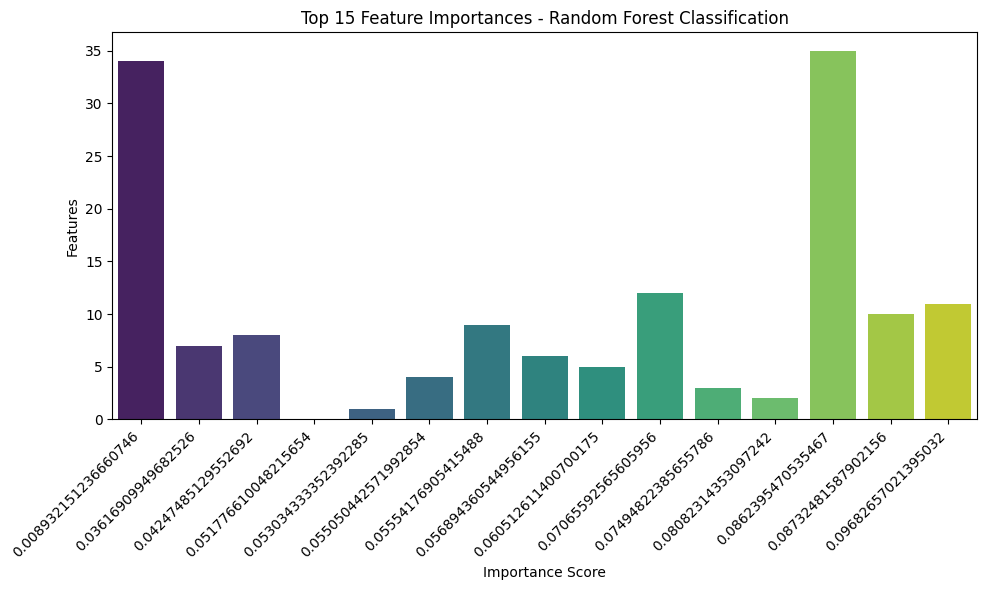

/tmp/ipykernel_963956/4227773593.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances_reg[:15], y=feat_importances_reg.index[:15], palette="coolwarm")


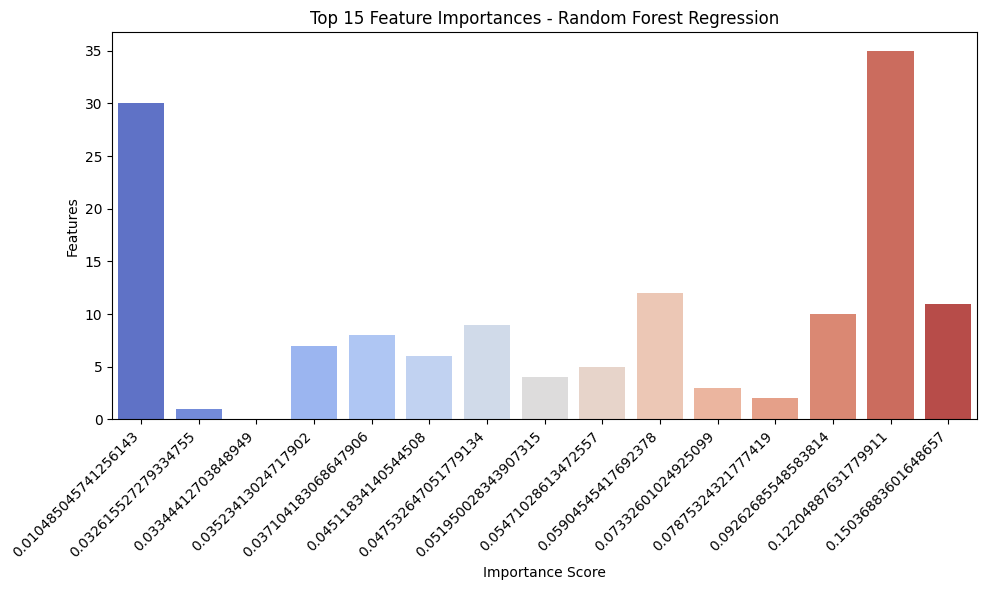

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Classification Feature Importance ===
feat_importances_class = pd.Series(rf_clf.feature_importances_, index=X_train_c.columns if isinstance(X_train_c, pd.DataFrame) else range(X_train_c.shape[1])).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances_class[:15], y=feat_importances_class.index[:15], palette="viridis")
plt.title("Top 15 Feature Importances - Random Forest Classification")
plt.xlabel("Importance Score")
plt.ylabel("Features")

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("data/eda/rf_classification_feature_importance.png")
plt.show()

# === Regression Feature Importance ===
feat_importances_reg = pd.Series(rf_reg.feature_importances_, index=X_train_r.columns if isinstance(X_train_r, pd.DataFrame) else range(X_train_r.shape[1])).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances_reg[:15], y=feat_importances_reg.index[:15], palette="coolwarm")
plt.title("Top 15 Feature Importances - Random Forest Regression")
plt.xlabel("Importance Score")
plt.ylabel("Features")

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("data/eda/rf_regression_feature_importance.png")
plt.show()
